In [1]:
from Parsa_Corrolation_edited_final import *
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from collections import deque
import random
import tensorflow as tf
import pyfolio as pf

F:\Wdigit\BourseMVPs-master\BourseMVPs-master\Bourse\newenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
F:\Wdigit\BourseMVPs-master\BourseMVPs-master\Bourse\newenv\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
F:\Wdigit\BourseMVPs-master\BourseMVPs-master\Bourse\newenv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Deploying Environment

In [34]:
class Environment:
    
    def __init__(self, pair1_id, pair2_id, begin_date, train_len, df):
        self.pair1_id = pair1_id
        self.pair2_id = pair2_id
        self.begin_date = begin_date
        self.train_len = train_len
        self.df = df
        self.trade_volume = 100
        self.portfolio = {'portfo_value':[],'long1':0}
        
    def spread(self): 
        Asset_1, Asset_2 = handle_nan(self.df[self.pair1_id], self.df[self.pair2_id])
        Asset_1  = add_constant(Asset_1)
        results = OLS(Asset_2, Asset_1).fit()
        coef = results.params[self.pair1_id]
        
        Asset_1 = Asset_1[self.pair1_id]
        spread = Asset_2 - (coef * Asset_1)
        spread_z_score = (spread - spread.mean()) / np.std(spread)
        
        date1 = datetime.datetime.strptime(self.begin_date, "%Y-%m-%d")
        date2 = date1 + relativedelta(months =+ self.train_len)
        
        return spread_z_score

## <span style="color:red"> Deploying Agent </span>

In [35]:
class agent():
    
    def __init__(self, state_size, action_space = ['buy', 'sell', 'hold']):
        self.state_size = state_size
        self.action_space = action_space
        self.memory = deque([],2000)
        self.inventory = []

        self.gammsa = 0.95
        self.epsilon = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 0.995
        
        self.model = self.model_builder()
        self.spread = Env.spread()
    
    def model_builder(self):
        model = tf.keras.models.Sequential()

        model.add(tf.keras.layers.Dense(units=32, activation='relu', input_dim=self.state_size))
        model.add(tf.keras.layers.Dense(units=64, activation='relu'))
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dense(units=len(self.action_space), activation='linear'))
                  
        model.compile(loss='mse', optimizer='adam')
        return model
    
    def state_creator(self, date, window_size = 5):
        idx = self.spread.index[spread.index == date][0]
        timestep = self.spread.index.get_loc(idx)
        
        starting_id = timestep - window_size + 1

        if starting_id >= 0:
            windowed_data = self.spread[starting_id:timestep + 1]
        else:
            windowed_data = starting_id * [self.spread[0]] + list(self.spread[0:timestep+1])

        state = []
        for i in range(window_size - 1):
            state.append(self.spread[i])

        return np.array([state])
                  
    def trade(self, state):
        if random.random() <= self.epsilon:
            return random.choice(self.action_space)
        
        actions = self.model.predict(state)
        
        return np.argmax(actions)
        
    def batch_train(self, batch_size):
        batch = []
        for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
            batch.append(self.memory[i])
        
        for state, action, reward, next_state, done in batch:
            reward = reward
            if not done:
                reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

            target = self.model.predict(state)
            target[0][action] = reward

            self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_final:
            self.epsilon *= self.epsilon_decay

## Deploying Strategy

In [36]:
class DRL_strategy(bt.Strategy):
    
    def log(self, txt, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}') 
        
    def __init__(self):
        self.spread = Env.spread()
        self.order_1 = None
        self.order_2 = None
        # saving the initial state
        self.state = trader.state_creator(spread.index[0], window_size + 1)
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                if (order.data._name == name1):
                    self.log(f'BUY EXECUTED, {order.executed.price:.2f}, for ASSET 1')
                elif (order.data._name == name2):
                    self.log(f'BUY EXECUTED, {order.executed.price:.2f}, for ASSET 2')
                    

            elif order.issell():
                if (order.data._name == name1):
                    self.log(f'SELL EXECUTED, {order.executed.price:.2f}, for ASSET 1')
                elif (order.data._name == name2):
                    self.log(f'SELL EXECUTED, {order.executed.price:.2f}, for ASSET 2')
        
            self.bar_executed = len(self)
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        # Reset Orders
        self.order_1 = None
        self.order_2 = None
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %d, NET %d' % (trade.pnl, trade.pnlcomm))
    
        
    
    #########################################################
    # this outer loop wont work !! how to use next inside a loop !
    #for episode in range(1, episodes + 1):
        
    #    trader.inventory = []
    #########################################################
        
    def next(self):
        # since not all of dates exists in our spread data => we should use try, except
        try:
            # Check for open orders
            if (self.order_1) and (self.order_2):
                return

            # take action from Action.trade and deploy it
            action = trader.trade(self.state)


            if (action == 'buy'):
                # open position = buy A, sell B
                if (Env.portfolio['long1'] >= 0):
                    self.order_1 = self.buy(data = data1, size = Env.trade_volume)
                    self.order_2 = self.sell(data = data2, size = Env.trade_volume)

                    Env.portfolio['long1'] = 1

                else:
                # close position = cloes A, close B    
                    self.order_1 = self.close(data = data1, size = Env.trade_volume)
                    self.order_2 = self.close(data = data2, size = Env.trade_volume)


                    Env.portfolio['long1'] = -1 if (self.order_1) else 0


            elif (action == 'sell'):
                # close position = close A, close B
                if (Env.portfolio['long1'] > 0):
                    self.order_1 = self.close(data = data1, size = Env.trade_volume)
                    self.order_2 = self.close(data = data2, size = Env.trade_volume)

                    Env.portfolio['long1'] = 1 if (self.order_1) else 0

                else:
                # open position = sell A, buy B    
                    self.order_1 = self.sell(data = data1, size = Env.trade_volume)
                    self.order_2 = self.buy(data = data2, size = Env.trade_volume)

                    Env.portfolio['long1'] = -1

            else:
                # action was hold
                pass

            # reward at each step = current portfolio value - previous portfolio value
            Env.portfolio['portfo_value'].append(cerebro.broker.get_value(datas=None, mkt=False, lever=False))
            n = len(Env.portfolio['portfo_value'])
            reward = Env.portfolio['portfo_value'][n-1] - Env.portfolio['portfo_value'][n-2]

            #########################################################
            # Next_state wont work properly ! it is always stuck in first state
            # getting state from environment
            next_state = trader.state_creator(str(self.datetime.date()), window_size + 1)

            #########################################################

            if str(self.datetime.date()) == END_DATE:
                done = True
            else:
                done = False

            print((state, action, reward, next_state, done))
            trader.memory.append((state, action, reward, next_state, done))
            #print(trader.memory)
            self.state = next_state

            if len(trader.memory) > batch_size:
                trader.batch_train(batch_size)

        except:
            pass

## Inputs

In [37]:
begin_date = "2019-08-01"
train_len = 24

pair1_id = 12
pair2_id = 26

window_size = 10
episodes = 1

batch_size = 32

## Here we prepare data to feed to backtrader <span style="color:red">Cerebro</span>

In [5]:
START_DATE = datetime.datetime.strptime(begin_date, "%Y-%m-%d")
END_DATE = START_DATE + relativedelta(months=+train_len)

available_stocks = list(Stock.objects.filter(
    stockhistory__date__gte=START_DATE,
    stockhistory__date__lte=END_DATE
).distinct())

stock_histories_repo = {}
for stock in tqdm(available_stocks, desc="Creating repository"):
    stock_histories = list(StockHistory.objects.filter(
        stock=stock,
        date__gte=START_DATE,
        date__lte=END_DATE
    ))
    stock_histories_repo[stock.name] = {}
    for stock_history in stock_histories:
        stock_histories_repo[stock.name][stock_history.date] = stock_history

Creating repository:   0%|          | 0/932 [00:00<?, ?it/s]

In [38]:
df, empty1 = data_to_df(str(START_DATE.date()), str(END_DATE.date()))
Env = Environment(pair1_id, pair2_id, begin_date, train_len, df)
trader = agent(window_size)
spread = Env.spread()

name1 = name_id[ids[pair1_id]]
name2 = name_id[ids[pair2_id]]

data1 = LocalBourseData(
        local_repo=stock_histories_repo,
        dataname=name1,
        fromdate=START_DATE,
        todate=END_DATE)

data2 = LocalBourseData(
        local_repo=stock_histories_repo,
        dataname=name2,
        fromdate=START_DATE,
        todate=END_DATE)

2019-08-06 SELL EXECUTED, 1422.00, for ASSET 1
2019-08-06 BUY EXECUTED, 1325.00, for ASSET 2
2019-08-07 BUY EXECUTED, 1470.00, for ASSET 1
2019-08-07 SELL EXECUTED, 1305.00, for ASSET 2
2019-08-07 OPERATION PROFIT, GROSS -4800, NET -4800
2019-08-07 OPERATION PROFIT, GROSS -2000, NET -2000
2019-08-17 SELL EXECUTED, 1580.00, for ASSET 1
2019-08-17 BUY EXECUTED, 1310.00, for ASSET 2
2019-08-18 SELL EXECUTED, 1544.00, for ASSET 1
2019-08-18 BUY EXECUTED, 1366.00, for ASSET 2
2019-08-19 SELL EXECUTED, 1640.00, for ASSET 1
2019-08-19 BUY EXECUTED, 1349.00, for ASSET 2
2019-08-24 BUY EXECUTED, 1722.00, for ASSET 1
2019-08-24 SELL EXECUTED, 1376.00, for ASSET 2
2019-08-26 BUY EXECUTED, 1660.00, for ASSET 1
2019-08-26 SELL EXECUTED, 1380.00, for ASSET 2
2019-08-27 BUY EXECUTED, 1800.00, for ASSET 1
2019-08-27 SELL EXECUTED, 1410.00, for ASSET 2
2019-08-27 OPERATION PROFIT, GROSS -41800, NET -41800
2019-08-27 OPERATION PROFIT, GROSS 14099, NET 14099
2019-09-04 SELL EXECUTED, 1601.00, for ASSET 1

<IPython.core.display.Javascript object>


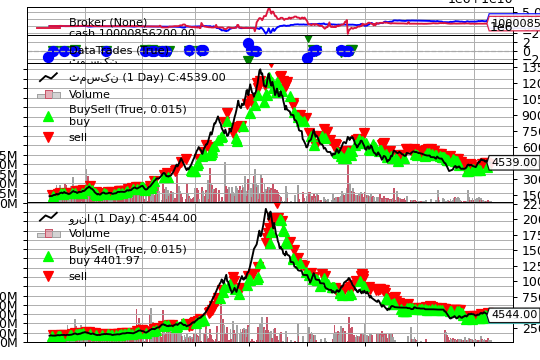

[[<Figure size 432x288 with 6 Axes>]]

In [43]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(1e10)
cerebro.adddata(data1)
cerebro.adddata(data2)

cerebro.addstrategy(DRL_strategy)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
cerebro.plot()

In [ ]:
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    live_start_date='2019-08-04',
    round_trips=True)